### Подключаем библиотеки

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import optuna
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.animation as animation
import os
from torchvision.io import read_image
from torchvision.transforms import v2
import torchvision
from torchvision.io import read_image, ImageReadMode

Напишем функцию read_data, который будет приводить dataframe к удобному виду.

In [3]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [4]:
def read_data_and_choose(path_to_file: str, velocity: float, load: bool) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    if load:
        load_value = 80
    else:
        load_value = 0
    data = data[(data['angular_velocity'] == velocity) & (data['load_value'] == load_value)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [5]:
def get_various_params_data(data: pd.DataFrame):
    return (data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 80)])

In [6]:
def do_rfft_features(data: pd.DataFrame) -> pd.DataFrame:
    y = data['defect']
    X = data.drop(columns=['defect']).values
    X_transformed = np.array(np.abs(rfft(X[0, :])))
    for i in range(1, X.shape[0]):
        X_transformed = np.vstack((X_transformed, np.abs(rfft(X[i, :]))))
    data = pd.DataFrame(X_transformed, y).reset_index().rename(columns={'index': 'defect'})
    return data

In [7]:
def get_features_and_target(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

In [8]:
def get_all_features_and_targets(n_cols: int, do_fft: bool) -> pd.DataFrame:
    data_1 = get_features_and_target(velocity=8.33203125, load=False, n_cols=n_cols)
    if do_fft:
        data_1 = do_rfft_features(data_1)
    data_1['velocity'] = 8.33203125
    data_1['load'] = 0.0
    data_2 = get_features_and_target(velocity=8.33203125, load=True, n_cols=n_cols)
    if do_fft:
        data_2 = do_rfft_features(data_2)
    data_2['velocity'] = 8.33203125
    data_2['load'] = 1.0
    data_3 = get_features_and_target(velocity=25.0, load=False, n_cols=n_cols)
    if do_fft:
        data_3 = do_rfft_features(data_3)
    data_3['velocity'] = 25.0
    data_3['load'] = 0.0
    data_4 = get_features_and_target(velocity=25.0, load=True, n_cols=n_cols)
    if do_fft:
        data_4 = do_rfft_features(data_4)
    data_4['velocity'] = 25.0
    data_4['load'] = 1.0
    data_5 = get_features_and_target(velocity=40.0, load=False, n_cols=n_cols)
    if do_fft:
        data_5 = do_rfft_features(data_5)
    data_5['velocity'] = 40.0
    data_5['load'] = 0.0
    data_6 = get_features_and_target(velocity=40.0, load=True, n_cols=n_cols)
    if do_fft:
        data_6 = do_rfft_features(data_6)
    data_6['velocity'] = 40.0
    data_6['load'] = 1.0
    data = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)
    data = data.reset_index().drop(columns='index', axis=1)
    return data

In [9]:
vel_list = [8.33203125, 25.0, 40.0]
data = get_features_and_target(velocity=vel_list[2], load=True, n_cols=150)
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [10]:
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [11]:
X = data.drop(columns='defect')
y = data['defect']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [14]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2024-04-30 15:22:25,430] A new study created in memory with name: no-name-cc8a1d3b-5edb-4f37-bb45-a14aebf1113e
[I 2024-04-30 15:22:28,683] Trial 6 finished with value: 0.30625 and parameters: {'learning_rate': 1.9203807870169862, 'num_leaves': 368, 'reg_lambda': 0.2580229256884048, 'reg_alpha': 0.7089501661351285, 'min_child_samples': 97}. Best is trial 6 with value: 0.30625.
[I 2024-04-30 15:22:29,768] Trial 4 finished with value: 0.4625 and parameters: {'learning_rate': 1.312330738640008, 'num_leaves': 3617, 'reg_lambda': 0.9119677736783589, 'reg_alpha': 0.3019604223678559, 'min_child_samples': 59}. Best is trial 4 with value: 0.4625.
[I 2024-04-30 15:22:30,711] Trial 1 finished with value: 0.48125 and parameters: {'learning_rate': 0.8595145924814568, 'num_leaves': 2478, 'reg_lambda': 0.44931960121569503, 'reg_alpha': 0.20652871068536127, 'min_child_samples': 91}. Best is trial 1 with value: 0.48125.
[I 2024-04-30 15:22:32,453] Trial 5 finished with value: 0.475 and parameters: {'

[I 2024-04-30 15:24:05,473] Trial 23 finished with value: 0.475 and parameters: {'learning_rate': 0.08940489745494407, 'num_leaves': 4078, 'reg_lambda': 0.5804853162034294, 'reg_alpha': 0.027693060046678708, 'min_child_samples': 1}. Best is trial 17 with value: 0.60625.
[I 2024-04-30 15:24:26,641] Trial 31 finished with value: 0.5375 and parameters: {'learning_rate': 0.531486495518863, 'num_leaves': 3741, 'reg_lambda': 0.008266185931391817, 'reg_alpha': 0.23731624172557858, 'min_child_samples': 74}. Best is trial 17 with value: 0.60625.
[I 2024-04-30 15:24:37,296] Trial 32 finished with value: 0.525 and parameters: {'learning_rate': 0.023324537571253356, 'num_leaves': 3602, 'reg_lambda': 0.3253994493394292, 'reg_alpha': 0.00018847721513067135, 'min_child_samples': 74}. Best is trial 17 with value: 0.60625.
[I 2024-04-30 15:24:37,334] Trial 34 finished with value: 0.63125 and parameters: {'learning_rate': 0.6086386644342798, 'num_leaves': 3756, 'reg_lambda': 0.15223465835149702, 'reg_al

In [16]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [17]:
accuracy

0.495

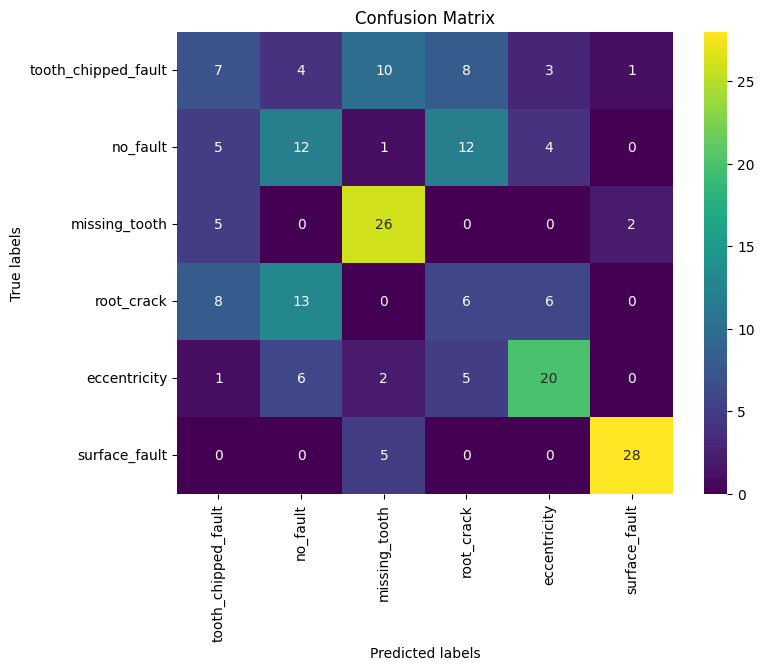

In [18]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Сделаем аналогичные действия для бинарной классификации

In [19]:
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [20]:
data['defect'] = np.where(data['defect'] == 'no_fault', 1.0, 0.0)

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,0.0,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,0.0,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,0.0,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,0.0,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,0.0,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.0,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,0.0,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,0.0,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,0.0,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [28]:
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,0.0,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,0.0,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,0.0,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,0.0,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,0.0,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.0,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,0.0,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,0.0,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,0.0,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [29]:
X = data.drop(columns='defect')
y = data['defect']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [41]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

In [42]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2024-04-30 15:33:17,675] A new study created in memory with name: no-name-01fbf41f-0e1d-4ae9-a59e-4dd3e8f07eb3
[I 2024-04-30 15:33:20,002] Trial 3 finished with value: 0.6778056251740463 and parameters: {'learning_rate': 1.8146568955024922, 'num_leaves': 2127, 'reg_lambda': 0.7410896411979284, 'reg_alpha': 0.921250958614619, 'min_child_samples': 14}. Best is trial 3 with value: 0.6778056251740463.
[I 2024-04-30 15:33:22,241] Trial 5 finished with value: 0.7404622667780563 and parameters: {'learning_rate': 0.283502501956367, 'num_leaves': 226, 'reg_lambda': 0.949781235639806, 'reg_alpha': 0.6076142467375593, 'min_child_samples': 2}. Best is trial 5 with value: 0.7404622667780563.
[I 2024-04-30 15:33:25,333] Trial 1 finished with value: 0.685602896129212 and parameters: {'learning_rate': 1.6487278176316036, 'num_leaves': 3880, 'reg_lambda': 0.3932405042068893, 'reg_alpha': 0.9291774769247888, 'min_child_samples': 76}. Best is trial 5 with value: 0.7404622667780563.
[I 2024-04-30 15:33

[I 2024-04-30 15:33:48,301] Trial 32 finished with value: 0.8373712057922584 and parameters: {'learning_rate': 0.29739297498167805, 'num_leaves': 654, 'reg_lambda': 0.37260754652105454, 'reg_alpha': 0.5291836233620199, 'min_child_samples': 47}. Best is trial 32 with value: 0.8373712057922584.
[I 2024-04-30 15:33:48,303] Trial 33 finished with value: 0.7825118351434142 and parameters: {'learning_rate': 0.37284215075291904, 'num_leaves': 821, 'reg_lambda': 0.3804864516857876, 'reg_alpha': 0.5628194929773954, 'min_child_samples': 50}. Best is trial 32 with value: 0.8373712057922584.
[I 2024-04-30 15:33:48,304] Trial 30 finished with value: 0.8095238095238095 and parameters: {'learning_rate': 0.29254731198688233, 'num_leaves': 788, 'reg_lambda': 0.3455309510908143, 'reg_alpha': 0.5468742476484423, 'min_child_samples': 42}. Best is trial 32 with value: 0.8373712057922584.
[I 2024-04-30 15:33:48,325] Trial 26 finished with value: 0.8340295182400446 and parameters: {'learning_rate': 0.3445021

In [46]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
accuracy

0.785

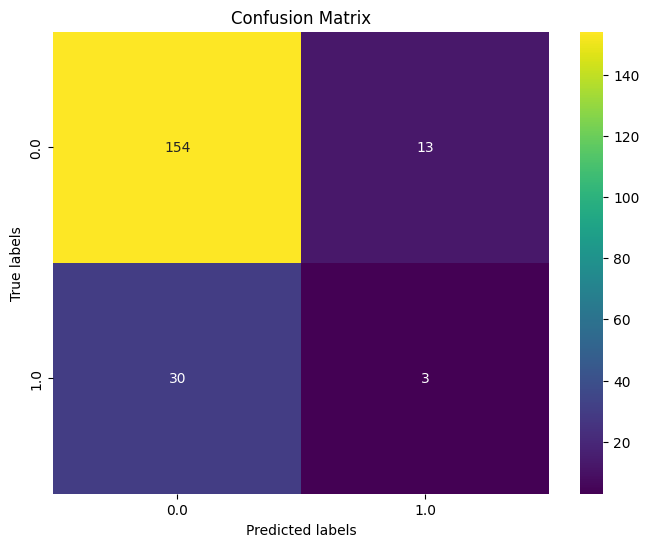

In [47]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
preds = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.7446924333151879

### Преобразование Фурье Мультиклассовая классификация

In [57]:
vel_list = [8.33203125, 25.0, 40.0]
data = get_features_and_target(velocity=vel_list[2], load=True, n_cols=150)
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [58]:
data = do_rfft_features(data)
data

,defect,0,1,2,3,4,5,6,7,8,...,66,67,68,69,70,71,72,73,74,75
0,eccentricity,525.300361,0.086251,0.064651,0.055709,0.043706,0.010399,0.103271,0.063116,0.107198,...,0.121369,0.017566,0.104780,0.062854,0.094239,0.057732,0.143755,0.179617,0.116678,0.155595
1,eccentricity,525.320228,0.096307,0.057703,0.065439,0.133730,0.086274,0.066657,0.029748,0.065393,...,0.134684,0.016750,0.073367,0.078766,0.061663,0.108380,0.117978,0.076330,0.068246,0.019819
2,eccentricity,525.290372,0.091189,0.041980,0.123393,0.072537,0.086720,0.108318,0.110195,0.095946,...,0.087457,0.052120,0.066383,0.148948,0.126035,0.218994,0.073965,0.042056,0.146307,0.034748
3,eccentricity,525.345796,0.051117,0.097616,0.082396,0.058996,0.025688,0.052397,0.013755,0.056942,...,0.075010,0.082815,0.018996,0.105550,0.112784,0.033298,0.119713,0.132907,0.015622,0.092434
4,eccentricity,525.055274,0.031709,0.104373,0.048793,0.069053,0.008650,0.103812,0.141121,0.052631,...,0.084934,0.100817,0.060511,0.079020,0.084821,0.163684,0.069359,0.114985,0.075826,0.097065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.300126,0.185319,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838
992,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.115612,0.256963,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946
993,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.057819,0.127003,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090
994,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.267125,0.161924,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863


In [59]:
data['defect'].value_counts()

defect
eccentricity           166
missing_tooth          166
no_fault               166
root_crack             166
surface_fault          166
tooth_chipped_fault    166
Name: count, dtype: int64

In [60]:
X = data.drop(columns='defect')
y = data['defect']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [63]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [64]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-04-30 15:39:40,944] A new study created in memory with name: no-name-6d902a16-480e-4017-b23e-5dcadfd990cb
[I 2024-04-30 15:39:42,478] Trial 0 finished with value: 0.95625 and parameters: {'learning_rate': 1.1226189466300485, 'num_leaves': 3910, 'reg_lambda': 0.6272921521476009, 'reg_alpha': 0.29254067116674465, 'min_child_samples': 98}. Best is trial 0 with value: 0.95625.
[I 2024-04-30 15:39:43,303] Trial 1 finished with value: 0.85625 and parameters: {'learning_rate': 1.9829113839736157, 'num_leaves': 1714, 'reg_lambda': 0.36374201562432484, 'reg_alpha': 0.9058848100531778, 'min_child_samples': 17}. Best is trial 0 with value: 0.95625.
[I 2024-04-30 15:39:43,856] Trial 2 finished with value: 0.95625 and parameters: {'learning_rate': 0.9768665924381202, 'num_leaves': 566, 'reg_lambda': 0.8486401164853494, 'reg_alpha': 0.019610171124678333, 'min_child_samples': 90}. Best is trial 0 with value: 0.95625.
[I 2024-04-30 15:39:44,704] Trial 3 finished with value: 0.93125 and paramet

[I 2024-04-30 15:40:25,472] Trial 30 finished with value: 0.975 and parameters: {'learning_rate': 0.7945988925613533, 'num_leaves': 3264, 'reg_lambda': 0.5633865097589, 'reg_alpha': 0.5525586060269629, 'min_child_samples': 26}. Best is trial 18 with value: 0.98125.
[I 2024-04-30 15:40:27,241] Trial 31 finished with value: 0.975 and parameters: {'learning_rate': 0.3721740857221882, 'num_leaves': 2567, 'reg_lambda': 0.4482857344787043, 'reg_alpha': 0.4269376147537226, 'min_child_samples': 23}. Best is trial 18 with value: 0.98125.
[I 2024-04-30 15:40:28,937] Trial 32 finished with value: 0.9625 and parameters: {'learning_rate': 0.5118026611429768, 'num_leaves': 2385, 'reg_lambda': 0.4000706554622984, 'reg_alpha': 0.479999307572746, 'min_child_samples': 36}. Best is trial 18 with value: 0.98125.
[I 2024-04-30 15:40:30,292] Trial 33 finished with value: 0.9625 and parameters: {'learning_rate': 0.31437686857038316, 'num_leaves': 1778, 'reg_lambda': 0.4535916153793559, 'reg_alpha': 0.3837721

In [65]:
print(study.best_params)

{'learning_rate': 0.37717745100547845, 'num_leaves': 2533, 'reg_lambda': 0.44899418369277555, 'reg_alpha': 0.44351511356926804, 'min_child_samples': 45}


In [66]:
best_params = {'learning_rate': 0.8814586632393469, 'num_leaves': 2290, 'reg_lambda': 0.9668567222949773, 'min_child_samples': 76}

In [67]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [68]:
accuracy

0.92

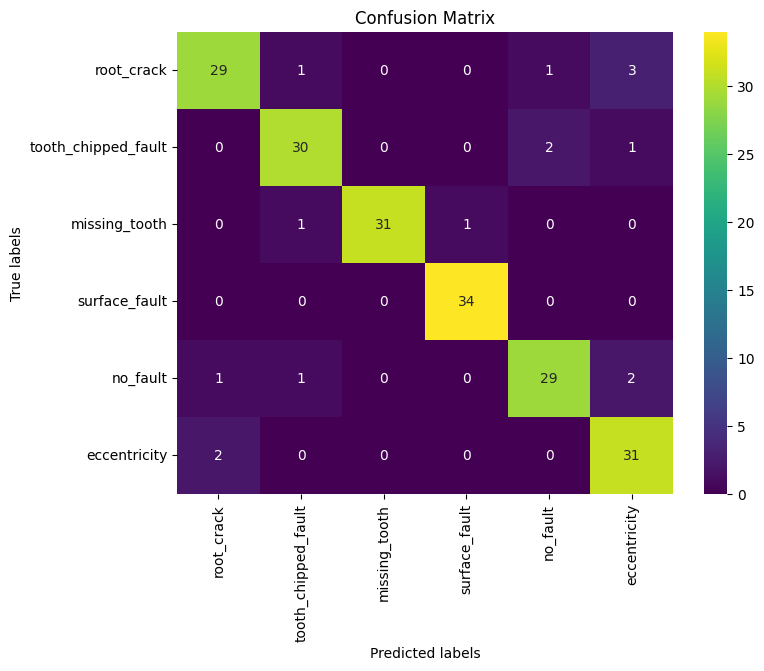

In [69]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [70]:
vel_list = [8.33203125, 25.0, 40.0]
data_eccentricity = read_data_and_choose('eccentricity.csv', velocity=vel_list[0], load=False)
eccentricity_time = data_eccentricity['time']
eccentricity_disp = data_eccentricity['displacements']
data_eccentricity

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.522315,2.431974,3.503794,8.332031,0,eccentricity
1,0.0002,2.523629,2.431317,3.504284,8.332031,0,eccentricity
2,0.0004,2.522644,2.428032,3.501296,8.332031,0,eccentricity
3,0.0006,2.521987,2.430660,3.502646,8.332031,0,eccentricity
4,0.0008,2.522808,2.430168,3.502895,8.332031,0,eccentricity
...,...,...,...,...,...,...,...
24995,4.9990,2.522479,2.431153,3.503342,8.332031,0,eccentricity
24996,4.9992,2.520180,2.432631,3.502713,8.332031,0,eccentricity
24997,4.9994,2.522644,2.427704,3.501068,8.332031,0,eccentricity
24998,4.9996,2.524286,2.430496,3.504188,8.332031,0,eccentricity


In [71]:
data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity=vel_list[0], load=False)
missing_tooth_time = data_missing_tooth['time']
missing_tooth_disp = data_missing_tooth['displacements']
data_missing_tooth

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.520016,2.430496,3.501113,8.332031,0,missing tooth
1,0.0002,2.521822,2.430660,3.502527,8.332031,0,missing tooth
2,0.0004,2.519194,2.429511,3.499837,8.332031,0,missing tooth
3,0.0006,2.519851,2.428853,3.499854,8.332031,0,missing tooth
4,0.0008,2.518701,2.429346,3.499369,8.332031,0,missing tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.519851,2.430168,3.500766,8.332031,0,missing tooth
24996,4.9992,2.520673,2.429018,3.500560,8.332031,0,missing tooth
24997,4.9994,2.519358,2.428032,3.498930,8.332031,0,missing tooth
24998,4.9996,2.520508,2.428689,3.500213,8.332031,0,missing tooth


In [72]:
data_no_fault = read_data_and_choose('no_fault.csv', velocity=vel_list[0], load=False)
no_fault_time = data_no_fault['time']
no_fault_disp = data_no_fault['displacements']
data_no_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.523465,2.430168,3.503368,8.332031,0,No fault
1,0.0002,2.521494,2.430003,3.501835,8.332031,0,No fault
2,0.0004,2.522479,2.429675,3.502317,8.332031,0,No fault
3,0.0006,2.521330,2.431810,3.502971,8.332031,0,No fault
4,0.0008,2.522479,2.431317,3.503456,8.332031,0,No fault
...,...,...,...,...,...,...,...
24995,4.9990,2.520508,2.429839,3.501011,8.332031,0,No fault
24996,4.9992,2.520016,2.431153,3.501569,8.332031,0,No fault
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,No fault
24998,4.9996,2.521165,2.432960,3.503651,8.332031,0,No fault


In [73]:
data_root_crack = read_data_and_choose('root_crack.csv', velocity=vel_list[0], load=False)
root_crack_time = data_root_crack['time']
root_crack_disp = data_root_crack['displacements']
data_root_crack

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.519358,2.429675,3.500070,8.332031,0,Root crack
1,0.0002,2.519358,2.429839,3.500184,8.332031,0,Root crack
2,0.0004,2.521165,2.430496,3.501940,8.332031,0,Root crack
3,0.0006,2.520508,2.428853,3.500327,8.332031,0,Root crack
4,0.0008,2.519358,2.428689,3.499385,8.332031,0,Root crack
...,...,...,...,...,...,...,...
24995,4.9990,2.521494,2.429839,3.501721,8.332031,0,Root crack
24996,4.9992,2.520837,2.430496,3.501704,8.332031,0,Root crack
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,Root crack
24998,4.9996,2.520837,2.429182,3.500792,8.332031,0,Root crack


In [74]:
data_surface_fault = read_data_and_choose('surface_fault.csv', velocity=vel_list[0], load=False)
surface_fault_time = data_surface_fault['time']
surface_fault_disp = data_surface_fault['displacements']
data_surface_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.521001,2.427539,3.499771,8.332031,0,surface defect
1,0.0002,2.519851,2.428196,3.499398,8.332031,0,surface defect
2,0.0004,2.520016,2.426225,3.498149,8.332031,0,surface defect
3,0.0006,2.520016,2.428689,3.499859,8.332031,0,surface defect
4,0.0008,2.521165,2.427047,3.499547,8.332031,0,surface defect
...,...,...,...,...,...,...,...
24995,4.9990,2.515581,2.430989,3.498264,8.332031,0,surface defect
24996,4.9992,2.491928,2.441173,3.488413,8.332031,0,surface defect
24997,4.9994,2.545804,2.416206,3.509867,8.332031,0,surface defect
24998,4.9996,2.518537,2.439694,3.506442,8.332031,0,surface defect


In [75]:
data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity=vel_list[0], load=False)
tooth_chipped_fault_time = data_tooth_chipped_fault['time']
tooth_chipped_fault_disp = data_tooth_chipped_fault['displacements']
data_tooth_chipped_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.518209,2.430496,3.499812,8.332031,0,chipped tooth
1,0.0002,2.517880,2.429839,3.499120,8.332031,0,chipped tooth
2,0.0004,2.516402,2.427211,3.496231,8.332031,0,chipped tooth
3,0.0006,2.518537,2.427704,3.498110,8.332031,0,chipped tooth
4,0.0008,2.518701,2.427539,3.498114,8.332031,0,chipped tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.516895,2.428361,3.497384,8.332031,0,chipped tooth
24996,4.9992,2.519030,2.429018,3.499377,8.332031,0,chipped tooth
24997,4.9994,2.519030,2.426882,3.497895,8.332031,0,chipped tooth
24998,4.9996,2.518209,2.430003,3.499470,8.332031,0,chipped tooth


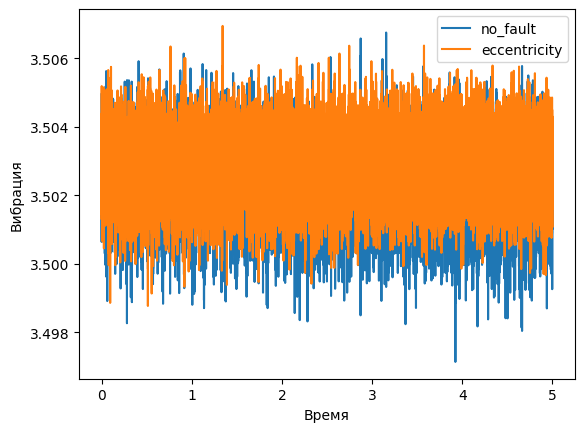

In [81]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

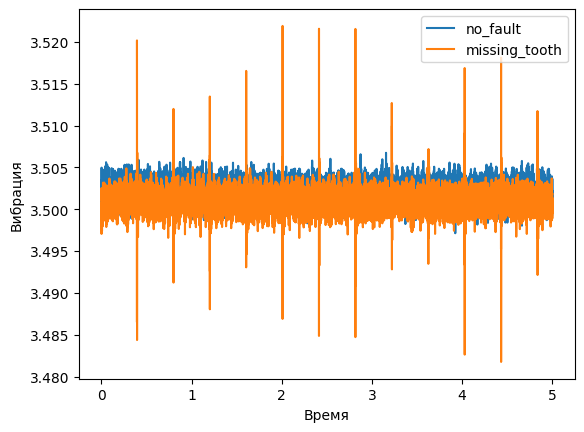

In [82]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(missing_tooth_time, missing_tooth_disp, label='missing_tooth')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

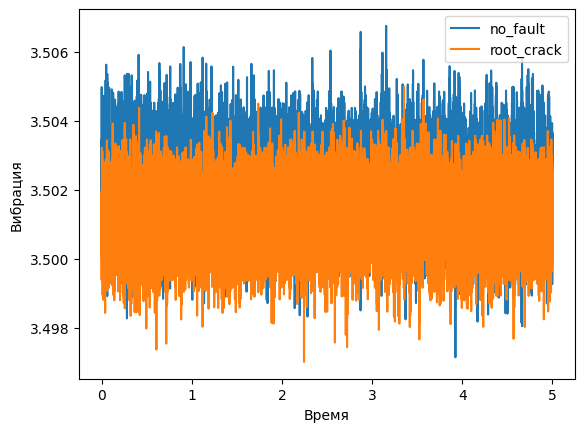

In [83]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(root_crack_time, root_crack_disp, label='root_crack')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

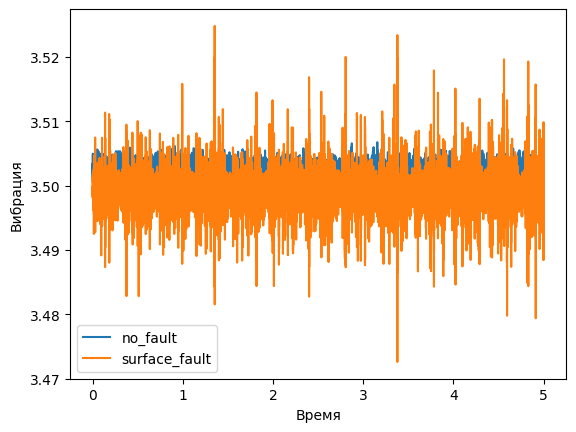

In [84]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(surface_fault_time, surface_fault_disp, label='surface_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

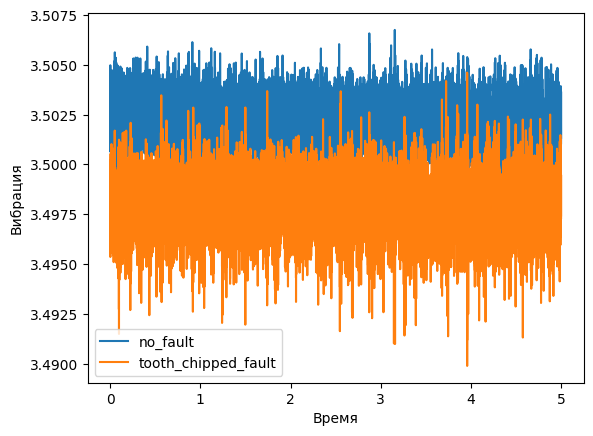

In [85]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(tooth_chipped_fault_time, tooth_chipped_fault_disp, label='tooth_chipped_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

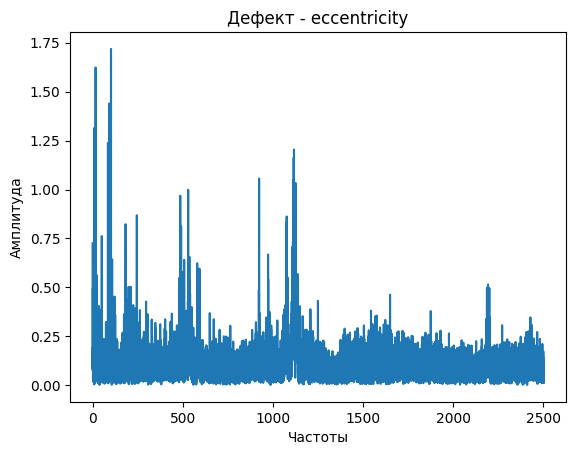

In [86]:
yf = rfft(eccentricity_disp.values)
xf = rfftfreq(n=eccentricity_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - eccentricity')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

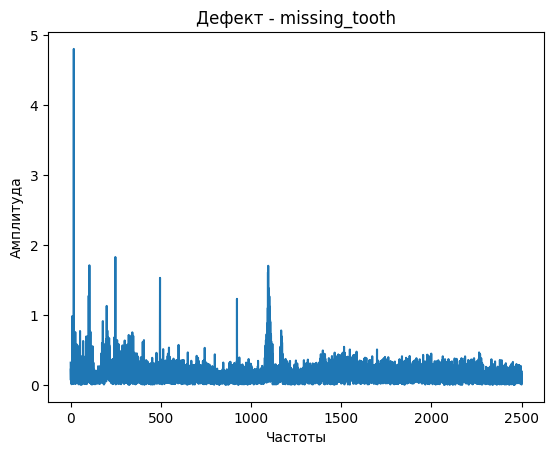

In [87]:
yf = rfft(missing_tooth_disp.values)
xf = rfftfreq(n=missing_tooth_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - missing_tooth')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

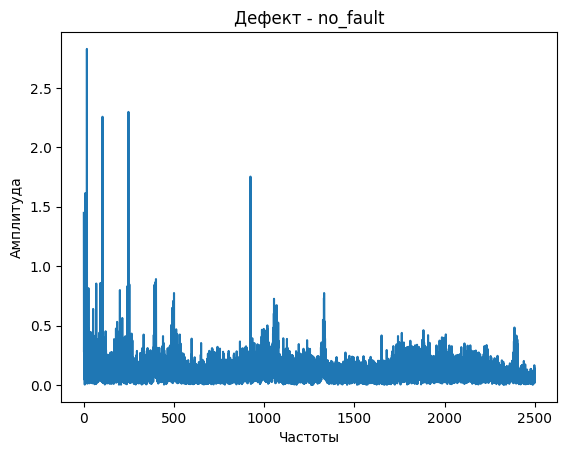

In [88]:
yf = rfft(no_fault_disp.values)
xf = rfftfreq(n=no_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - no_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

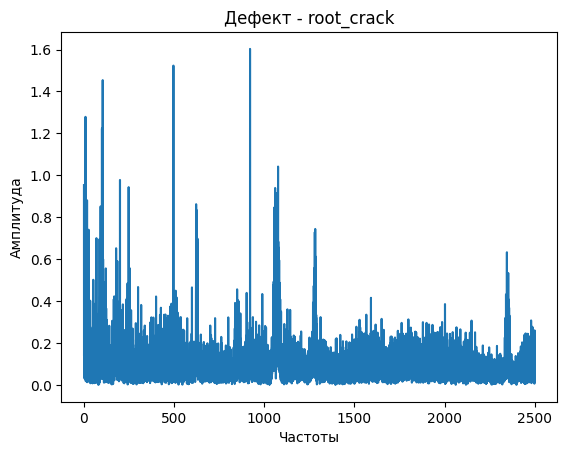

In [89]:
yf = rfft(root_crack_disp.values)
xf = rfftfreq(n=root_crack_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - root_crack')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

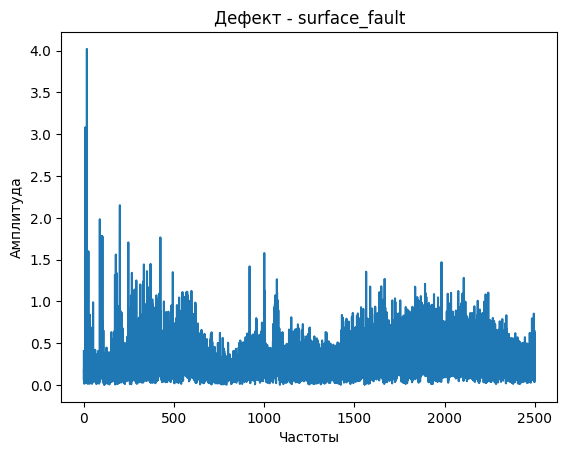

In [90]:
yf = rfft(surface_fault_disp.values)
xf = rfftfreq(n=surface_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - surface_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

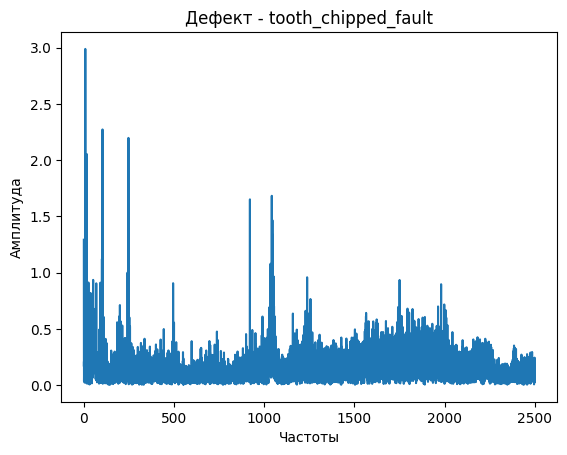

In [91]:
yf = rfft(tooth_chipped_fault_disp.values)
xf = rfftfreq(n=tooth_chipped_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - tooth_chipped_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

## Все данные

In [93]:
big_data = get_all_features_and_targets(n_cols=150, do_fft=True)
big_data

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,1.0
5972,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,1.0
5973,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,1.0
5974,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,1.0


In [96]:
X = big_data.drop(columns='defect')
y = big_data['defect']

In [97]:
cat_cols = ['velocity', 'load']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [100]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train, categorical_feature=cat_cols)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [101]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=100)

[I 2024-04-30 15:43:48,440] A new study created in memory with name: no-name-3fe03611-95fa-415b-8c40-d8771e6f715b
[I 2024-04-30 15:43:50,320] Trial 0 finished with value: 0.9560669456066946 and parameters: {'learning_rate': 0.43096758584131406, 'num_leaves': 3788, 'reg_lambda': 0.909598884470098, 'reg_alpha': 0.3268354321355563, 'min_child_samples': 42}. Best is trial 0 with value: 0.9560669456066946.
[I 2024-04-30 15:43:51,959] Trial 1 finished with value: 0.6192468619246861 and parameters: {'learning_rate': 1.8047847758728932, 'num_leaves': 3731, 'reg_lambda': 0.18910096759032846, 'reg_alpha': 0.5741860112013719, 'min_child_samples': 34}. Best is trial 0 with value: 0.9560669456066946.
[I 2024-04-30 15:43:54,632] Trial 2 finished with value: 0.893305439330544 and parameters: {'learning_rate': 0.008792632701450424, 'num_leaves': 3511, 'reg_lambda': 0.5827348195874105, 'reg_alpha': 0.5802583222920973, 'min_child_samples': 58}. Best is trial 0 with value: 0.9560669456066946.
[I 2024-04-

[I 2024-04-30 15:44:46,792] Trial 28 finished with value: 0.9623430962343096 and parameters: {'learning_rate': 0.15696960764979195, 'num_leaves': 1911, 'reg_lambda': 0.8847752704852961, 'reg_alpha': 0.18362877028410418, 'min_child_samples': 19}. Best is trial 22 with value: 0.9654811715481172.
[I 2024-04-30 15:44:49,761] Trial 29 finished with value: 0.9581589958158996 and parameters: {'learning_rate': 0.4009327687025109, 'num_leaves': 3293, 'reg_lambda': 0.907754839764368, 'reg_alpha': 0.06313171159480374, 'min_child_samples': 37}. Best is trial 22 with value: 0.9654811715481172.
[I 2024-04-30 15:44:52,140] Trial 30 finished with value: 0.9571129707112971 and parameters: {'learning_rate': 0.34521626803958266, 'num_leaves': 1382, 'reg_lambda': 0.9821817413278171, 'reg_alpha': 0.0021737084749157073, 'min_child_samples': 43}. Best is trial 22 with value: 0.9654811715481172.
[I 2024-04-30 15:44:56,471] Trial 31 finished with value: 0.9633891213389121 and parameters: {'learning_rate': 0.20

In [102]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train, categorical_feature=cat_cols)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [103]:
accuracy

0.9531772575250836

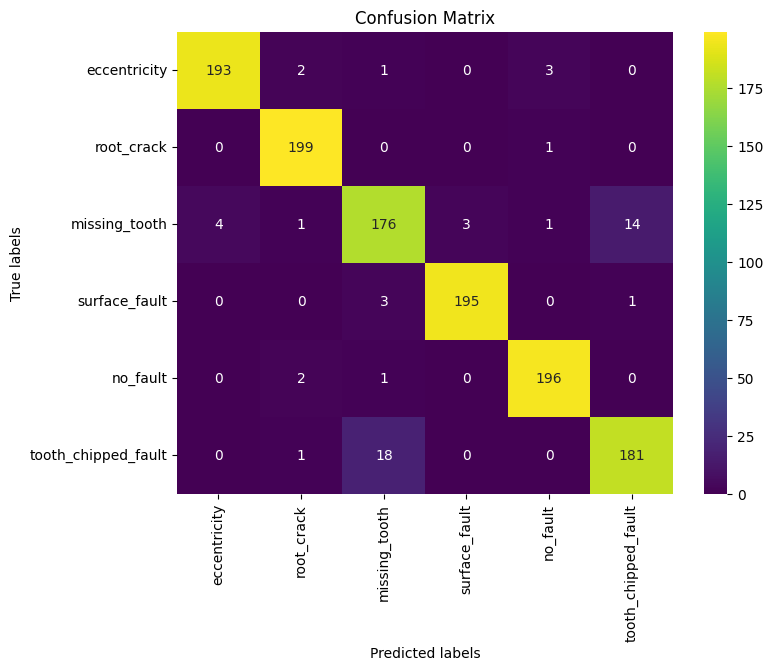

In [104]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Аналогично для бинарной классификации

In [105]:
big_data = get_all_features_and_targets(n_cols=150, do_fft=True)
big_data

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,1.0
5972,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,1.0
5973,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,1.0
5974,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,1.0


In [106]:
big_data['defect'] = np.where(big_data['defect'] == 'no_fault', 1.0, 0.0)
big_data

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,0.0,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,0.0,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,0.0,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,0.0,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,0.0,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.0,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,1.0
5972,0.0,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,1.0
5973,0.0,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,1.0
5974,0.0,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,1.0


In [107]:
X = big_data.drop(columns='defect')
y = big_data['defect']

In [108]:
cat_cols = ['velocity', 'load']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [110]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [111]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

In [112]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2024-04-30 15:49:01,312] A new study created in memory with name: no-name-e77c0de2-8460-4163-953a-6f3493e25e7e
[I 2024-04-30 15:49:03,947] Trial 0 finished with value: 0.9936712356872865 and parameters: {'learning_rate': 1.8919328003103033, 'num_leaves': 635, 'reg_lambda': 0.807915984555421, 'reg_alpha': 0.30950284972472064, 'min_child_samples': 32}. Best is trial 0 with value: 0.9936712356872865.
[I 2024-04-30 15:49:04,019] Trial 4 finished with value: 0.9974037862108693 and parameters: {'learning_rate': 1.0216688090327017, 'num_leaves': 116, 'reg_lambda': 0.7260488967070853, 'reg_alpha': 0.7773020034513324, 'min_child_samples': 24}. Best is trial 4 with value: 0.9974037862108693.
[I 2024-04-30 15:49:04,707] Trial 3 finished with value: 0.9608476756389922 and parameters: {'learning_rate': 1.6953349145471874, 'num_leaves': 21, 'reg_lambda': 0.31912961967871345, 'reg_alpha': 0.2272726641536682, 'min_child_samples': 99}. Best is trial 4 with value: 0.9974037862108693.
[I 2024-04-30 15

[I 2024-04-30 15:49:38,661] Trial 28 finished with value: 0.9995186351333223 and parameters: {'learning_rate': 0.5738405509865316, 'num_leaves': 3990, 'reg_lambda': 0.3860395224498555, 'reg_alpha': 0.002409470274323519, 'min_child_samples': 55}. Best is trial 22 with value: 0.9998737403628387.
[I 2024-04-30 15:49:40,015] Trial 29 finished with value: 0.9997632631803225 and parameters: {'learning_rate': 0.572633361870386, 'num_leaves': 4014, 'reg_lambda': 0.3832679534312804, 'reg_alpha': 0.12373070504060776, 'min_child_samples': 88}. Best is trial 22 with value: 0.9998737403628387.
[I 2024-04-30 15:49:43,352] Trial 33 finished with value: 0.9994081579508061 and parameters: {'learning_rate': 0.7066845621320768, 'num_leaves': 3028, 'reg_lambda': 0.9976981156109312, 'reg_alpha': 0.13106531381169012, 'min_child_samples': 89}. Best is trial 22 with value: 0.9998737403628387.
[I 2024-04-30 15:49:43,354] Trial 31 finished with value: 0.9993844842688384 and parameters: {'learning_rate': 0.62870

In [119]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train, categorical_feature=cat_cols)

preds = clf.predict(X_test)
accuracy = balanced_accuracy_score(y_test, preds)
accuracy

0.9643226160894744

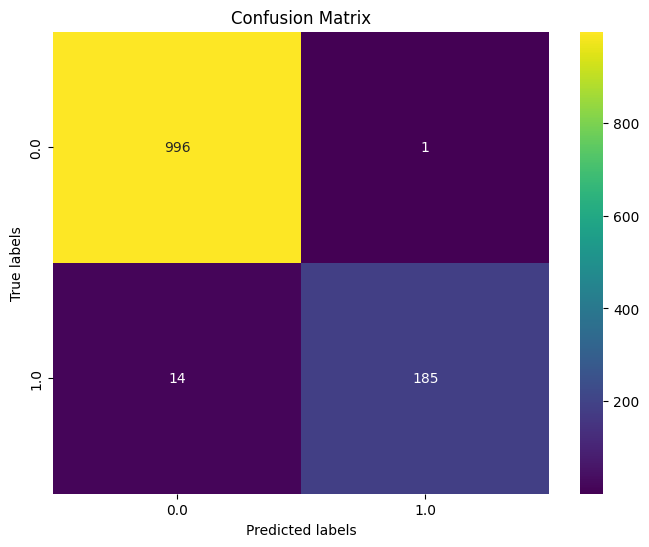

In [114]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [116]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train, categorical_feature=cat_cols)

preds = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9954385770376456

# Попробуем обойтись без использования перехода к одной переменной.

In [120]:
def get_x_disp_data(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements_x'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements_x'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements_x'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements_x'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements_x'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements_x'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements_x'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements_x'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements_x'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements_x'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements_x'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements_x'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    
def get_y_disp_data(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements_y'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements_y'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements_y'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements_y'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements_y'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements_y'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements_y'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements_y'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements_y'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements_y'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements_y'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements_y'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

def get_x_and_y_disp_data_all(n_cols: int, do_fft: bool) -> pd.DataFrame:
    data_1 = get_x_disp_data(velocity=8.33203125, load=False, n_cols=n_cols)
    if do_fft:
        data_1 = do_rfft_features(data_1)
    data_1['velocity'] = 8.33203125
    data_1['load'] = 0.0
    data_2 = get_x_disp_data(velocity=8.33203125, load=True, n_cols=n_cols)
    if do_fft:
        data_2 = do_rfft_features(data_2)
    data_2['velocity'] = 8.33203125
    data_2['load'] = 1.0
    data_3 = get_x_disp_data(velocity=25.0, load=False, n_cols=n_cols)
    if do_fft:
        data_3 = do_rfft_features(data_3)
    data_3['velocity'] = 25.0
    data_3['load'] = 0.0
    data_4 = get_x_disp_data(velocity=25.0, load=True, n_cols=n_cols)
    if do_fft:
        data_4 = do_rfft_features(data_4)
    data_4['velocity'] = 25.0
    data_4['load'] = 1.0
    data_5 = get_x_disp_data(velocity=40.0, load=False, n_cols=n_cols)
    if do_fft:
        data_5 = do_rfft_features(data_5)
    data_5['velocity'] = 40.0
    data_5['load'] = 0.0
    data_6 = get_x_disp_data(velocity=40.0, load=True, n_cols=n_cols)
    if do_fft:
        data_6 = do_rfft_features(data_6)
    data_6['velocity'] = 40.0
    data_6['load'] = 1.0
    data_x = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)
    data_x = data_x.reset_index().drop(columns='index', axis=1)
    
    
    data_7 = get_y_disp_data(velocity=8.33203125, load=False, n_cols=n_cols)
    if do_fft:
        data_7 = do_rfft_features(data_7)
    data_7['velocity'] = 8.33203125
    data_7['load'] = 0.0
    data_8 = get_y_disp_data(velocity=8.33203125, load=True, n_cols=n_cols)
    if do_fft:
        data_8 = do_rfft_features(data_8)
    data_8['velocity'] = 8.33203125
    data_8['load'] = 1.0
    data_9 = get_y_disp_data(velocity=25.0, load=False, n_cols=n_cols)
    if do_fft:
        data_9 = do_rfft_features(data_9)
    data_9['velocity'] = 25.0
    data_9['load'] = 0.0
    data_10 = get_y_disp_data(velocity=25.0, load=True, n_cols=n_cols)
    if do_fft:
        data_10 = do_rfft_features(data_10)
    data_10['velocity'] = 25.0
    data_10['load'] = 1.0
    data_11 = get_y_disp_data(velocity=40.0, load=False, n_cols=n_cols)
    if do_fft:
        data_11 = do_rfft_features(data_11)
    data_11['velocity'] = 40.0
    data_11['load'] = 0.0
    data_12 = get_y_disp_data(velocity=40.0, load=True, n_cols=n_cols)
    if do_fft:
        data_12 = do_rfft_features(data_12)
    data_12['velocity'] = 40.0
    data_12['load'] = 1.0
    data_y = pd.concat([data_7, data_8, data_9, data_10, data_11, data_12], axis=0)
    data_y = data_y.reset_index().drop(columns='index', axis=1)
    
    
    
    return data_x, data_y

In [121]:
data_x, data_y = get_x_and_y_disp_data_all(n_cols=150, do_fft=True)
data_x

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,378.277293,0.015717,0.008668,0.015948,0.002384,0.009677,0.022668,0.006352,0.004364,...,0.009529,0.008881,0.016543,0.009633,0.006000,0.012344,0.004581,0.004599,8.332031,0.0
1,eccentricity,378.278278,0.024975,0.014630,0.023526,0.014165,0.015262,0.015294,0.001645,0.005744,...,0.010389,0.007322,0.002010,0.002648,0.013646,0.009713,0.009459,0.015112,8.332031,0.0
2,eccentricity,378.259389,0.034753,0.008669,0.023839,0.014624,0.011811,0.011779,0.009778,0.009150,...,0.014681,0.000462,0.006320,0.011315,0.004697,0.006135,0.013589,0.010020,8.332031,0.0
3,eccentricity,378.274008,0.023364,0.007415,0.027063,0.012314,0.013260,0.001257,0.022421,0.006262,...,0.011157,0.012448,0.012905,0.000713,0.006651,0.007788,0.014083,0.003614,8.332031,0.0
4,eccentricity,378.260046,0.012817,0.003284,0.021048,0.007689,0.007029,0.020250,0.002913,0.005924,...,0.004056,0.007001,0.005135,0.008884,0.004487,0.013099,0.004397,0.006077,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,378.027624,0.069320,0.069553,0.114717,0.036231,0.077207,0.025596,0.087047,0.074084,...,0.353368,0.397311,0.034718,0.231279,0.101014,0.185434,0.192182,0.259525,40.000000,1.0
5972,tooth_chipped_fault,378.026474,0.100437,0.025400,0.078990,0.038471,0.038863,0.038734,0.054085,0.066473,...,0.355668,0.318505,0.113988,0.311476,0.109484,0.147537,0.019846,0.115144,40.000000,1.0
5973,tooth_chipped_fault,378.085935,0.035138,0.124947,0.084993,0.024351,0.071019,0.033363,0.029967,0.040120,...,0.081018,0.159992,0.356666,0.365780,0.176889,0.112215,0.231519,0.008705,40.000000,1.0
5974,tooth_chipped_fault,377.949931,0.042399,0.044901,0.075003,0.061029,0.013571,0.035042,0.044659,0.062520,...,0.049167,0.203758,0.200413,0.067314,0.232689,0.217881,0.011587,0.142410,40.000000,1.0


In [122]:
data_y

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,364.638632,0.017552,0.015278,0.025026,0.012105,0.008791,0.024672,0.015236,0.001255,...,0.008208,0.007663,0.013453,0.009579,0.013085,0.024334,0.005738,0.002135,8.332031,0.0
1,eccentricity,364.663270,0.001898,0.006828,0.022923,0.001453,0.008137,0.010911,0.010935,0.008795,...,0.005102,0.012435,0.009559,0.004153,0.010308,0.008897,0.009448,0.013962,8.332031,0.0
2,eccentricity,364.691522,0.030395,0.015014,0.007338,0.016197,0.008806,0.015666,0.006246,0.010162,...,0.002194,0.007932,0.008543,0.007471,0.007064,0.003184,0.001779,0.003778,8.332031,0.0
3,eccentricity,364.685773,0.023773,0.002966,0.009054,0.008698,0.013719,0.009995,0.006462,0.009086,...,0.019457,0.015109,0.012414,0.011125,0.002945,0.014372,0.012947,0.004271,8.332031,0.0
4,eccentricity,364.665077,0.008009,0.009693,0.017936,0.004595,0.003575,0.011958,0.018999,0.008491,...,0.005531,0.012223,0.014594,0.002103,0.006063,0.013777,0.007870,0.027266,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,364.604303,0.067198,0.134530,0.160636,0.165534,0.065152,0.123384,0.049386,0.106693,...,0.187432,0.158239,0.208053,0.186699,0.325453,0.185574,0.207687,0.376474,40.000000,1.0
5972,tooth_chipped_fault,364.435284,0.070545,0.125002,0.126409,0.037659,0.146888,0.061814,0.061451,0.052470,...,0.406897,0.270198,0.306999,0.509071,0.168997,0.284416,0.082001,0.072108,40.000000,1.0
5973,tooth_chipped_fault,364.619907,0.062509,0.036295,0.147571,0.170170,0.078890,0.035779,0.051646,0.041183,...,0.195643,0.281575,0.422535,0.358664,0.211841,0.092814,0.183104,0.153908,40.000000,1.0
5974,tooth_chipped_fault,364.442347,0.025992,0.116412,0.133673,0.082888,0.006573,0.077853,0.102054,0.054155,...,0.139824,0.324380,0.122465,0.326499,0.372937,0.254669,0.242221,0.016754,40.000000,1.0


In [123]:
data_y.rename(columns=dict(zip([i for i in range(data_x.columns.values[-3] + 1)], [i for i in range(data_x.columns.values[-3] + 1, data_x.columns.values[-3] - 2 + len(data_x.columns.values))])), inplace=True)
data_y.drop(columns=['defect', 'velocity', 'load'], inplace=True)

In [124]:
data_y

,76,77,78,79,80,81,82,83,84,85,...,142,143,144,145,146,147,148,149,150,151
0,364.638632,0.017552,0.015278,0.025026,0.012105,0.008791,0.024672,0.015236,0.001255,0.016432,...,0.023325,0.015019,0.008208,0.007663,0.013453,0.009579,0.013085,0.024334,0.005738,0.002135
1,364.663270,0.001898,0.006828,0.022923,0.001453,0.008137,0.010911,0.010935,0.008795,0.010107,...,0.002492,0.013147,0.005102,0.012435,0.009559,0.004153,0.010308,0.008897,0.009448,0.013962
2,364.691522,0.030395,0.015014,0.007338,0.016197,0.008806,0.015666,0.006246,0.010162,0.005783,...,0.013371,0.014224,0.002194,0.007932,0.008543,0.007471,0.007064,0.003184,0.001779,0.003778
3,364.685773,0.023773,0.002966,0.009054,0.008698,0.013719,0.009995,0.006462,0.009086,0.007334,...,0.018976,0.010934,0.019457,0.015109,0.012414,0.011125,0.002945,0.014372,0.012947,0.004271
4,364.665077,0.008009,0.009693,0.017936,0.004595,0.003575,0.011958,0.018999,0.008491,0.014564,...,0.012556,0.008708,0.005531,0.012223,0.014594,0.002103,0.006063,0.013777,0.007870,0.027266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,364.604303,0.067198,0.134530,0.160636,0.165534,0.065152,0.123384,0.049386,0.106693,0.062483,...,0.153285,0.220217,0.187432,0.158239,0.208053,0.186699,0.325453,0.185574,0.207687,0.376474
5972,364.435284,0.070545,0.125002,0.126409,0.037659,0.146888,0.061814,0.061451,0.052470,0.057433,...,0.281413,0.179622,0.406897,0.270198,0.306999,0.509071,0.168997,0.284416,0.082001,0.072108
5973,364.619907,0.062509,0.036295,0.147571,0.170170,0.078890,0.035779,0.051646,0.041183,0.036434,...,0.037335,0.149321,0.195643,0.281575,0.422535,0.358664,0.211841,0.092814,0.183104,0.153908
5974,364.442347,0.025992,0.116412,0.133673,0.082888,0.006573,0.077853,0.102054,0.054155,0.072834,...,0.175105,0.201232,0.139824,0.324380,0.122465,0.326499,0.372937,0.254669,0.242221,0.016754


In [125]:
data = pd.concat([data_x, data_y], axis=1)
data

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,150,151
0,eccentricity,378.277293,0.015717,0.008668,0.015948,0.002384,0.009677,0.022668,0.006352,0.004364,...,0.023325,0.015019,0.008208,0.007663,0.013453,0.009579,0.013085,0.024334,0.005738,0.002135
1,eccentricity,378.278278,0.024975,0.014630,0.023526,0.014165,0.015262,0.015294,0.001645,0.005744,...,0.002492,0.013147,0.005102,0.012435,0.009559,0.004153,0.010308,0.008897,0.009448,0.013962
2,eccentricity,378.259389,0.034753,0.008669,0.023839,0.014624,0.011811,0.011779,0.009778,0.009150,...,0.013371,0.014224,0.002194,0.007932,0.008543,0.007471,0.007064,0.003184,0.001779,0.003778
3,eccentricity,378.274008,0.023364,0.007415,0.027063,0.012314,0.013260,0.001257,0.022421,0.006262,...,0.018976,0.010934,0.019457,0.015109,0.012414,0.011125,0.002945,0.014372,0.012947,0.004271
4,eccentricity,378.260046,0.012817,0.003284,0.021048,0.007689,0.007029,0.020250,0.002913,0.005924,...,0.012556,0.008708,0.005531,0.012223,0.014594,0.002103,0.006063,0.013777,0.007870,0.027266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,378.027624,0.069320,0.069553,0.114717,0.036231,0.077207,0.025596,0.087047,0.074084,...,0.153285,0.220217,0.187432,0.158239,0.208053,0.186699,0.325453,0.185574,0.207687,0.376474
5972,tooth_chipped_fault,378.026474,0.100437,0.025400,0.078990,0.038471,0.038863,0.038734,0.054085,0.066473,...,0.281413,0.179622,0.406897,0.270198,0.306999,0.509071,0.168997,0.284416,0.082001,0.072108
5973,tooth_chipped_fault,378.085935,0.035138,0.124947,0.084993,0.024351,0.071019,0.033363,0.029967,0.040120,...,0.037335,0.149321,0.195643,0.281575,0.422535,0.358664,0.211841,0.092814,0.183104,0.153908
5974,tooth_chipped_fault,377.949931,0.042399,0.044901,0.075003,0.061029,0.013571,0.035042,0.044659,0.062520,...,0.175105,0.201232,0.139824,0.324380,0.122465,0.326499,0.372937,0.254669,0.242221,0.016754


In [126]:
X = data.drop(columns='defect')
y = data['defect']

In [127]:
cat_cols = ['velocity', 'load']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [129]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train, categorical_feature=cat_cols)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [130]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=100)

[I 2024-04-30 15:56:10,386] A new study created in memory with name: no-name-1b35677a-6431-4d2f-9cd4-78fcfbae763c
[I 2024-04-30 15:56:13,334] Trial 0 finished with value: 0.8242677824267782 and parameters: {'learning_rate': 1.6279363945533083, 'num_leaves': 1082, 'reg_lambda': 0.5264070929370573, 'reg_alpha': 0.19429702360411494, 'min_child_samples': 97}. Best is trial 0 with value: 0.8242677824267782.
[I 2024-04-30 15:56:18,213] Trial 1 finished with value: 0.9728033472803347 and parameters: {'learning_rate': 0.5073460868293069, 'num_leaves': 2717, 'reg_lambda': 0.30255758851847914, 'reg_alpha': 0.4190609768250594, 'min_child_samples': 54}. Best is trial 1 with value: 0.9728033472803347.
[I 2024-04-30 15:56:24,617] Trial 2 finished with value: 0.9728033472803347 and parameters: {'learning_rate': 0.22605118250561093, 'num_leaves': 3262, 'reg_lambda': 0.15578406477949436, 'reg_alpha': 0.698187198246827, 'min_child_samples': 28}. Best is trial 1 with value: 0.9728033472803347.
[I 2024-04

[I 2024-04-30 15:57:53,662] Trial 28 finished with value: 0.9748953974895398 and parameters: {'learning_rate': 0.10526014398190497, 'num_leaves': 3621, 'reg_lambda': 0.10048553548819406, 'reg_alpha': 0.5176106541705112, 'min_child_samples': 34}. Best is trial 25 with value: 0.9780334728033473.


In [131]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train, categorical_feature=cat_cols)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [132]:
accuracy

0.9657190635451505

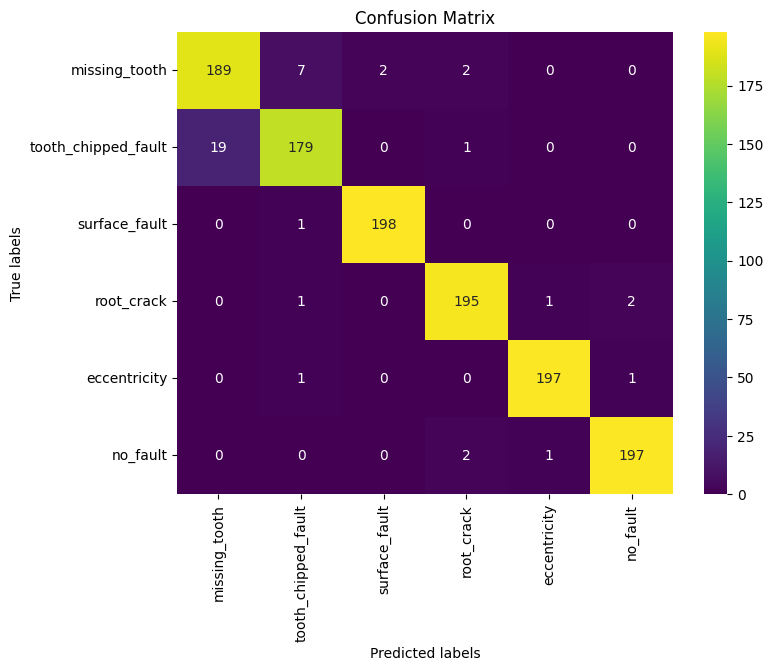

In [133]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Torch

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [118]:
big_data = get_all_features_and_targets(n_cols=250, do_fft=True)

In [129]:
class Custom_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, scale_num: bool, OHE: bool):
        if scale_num:
            num_cols = df.drop(columns=['defect', 'velocity', 'load']).columns
            scaler = StandardScaler()
            df[num_cols] = scaler.fit_transform(df[num_cols])
        if OHE:
            df = pd.get_dummies(df, columns=['velocity', 'load'], dtype=int)
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        feature = self.df.drop(columns='defect').values
        feature = np.array(feature, dtype=np.float32)
        label = self.df['defect'].values
        label = np.array(label, dtype=np.int32)
        return feature[idx, :], label[idx]

In [130]:
label_enc = LabelEncoder()
big_data['defect'] = label_enc.fit_transform(big_data['defect'])
big_data

,defect,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,velocity,load
0,0,875.679017,0.038911,0.008500,0.013639,0.014923,0.025569,0.011123,0.008206,0.004259,...,0.006249,0.009443,0.020087,0.014354,0.011282,0.005593,0.008005,0.006557,8.332031,0.0
1,0,875.730611,0.038902,0.015310,0.003557,0.027419,0.016622,0.004436,0.015183,0.006932,...,0.003852,0.006691,0.007187,0.014311,0.002935,0.003929,0.015655,0.014798,8.332031,0.0
2,0,875.715445,0.020772,0.013412,0.008526,0.028259,0.025518,0.005779,0.008611,0.009036,...,0.007863,0.013159,0.011201,0.008342,0.010083,0.010577,0.007352,0.018694,8.332031,0.0
3,0,875.717958,0.045097,0.009934,0.010681,0.024365,0.023930,0.015251,0.015295,0.017969,...,0.009960,0.012790,0.021793,0.012624,0.006577,0.010387,0.010233,0.008609,8.332031,0.0
4,0,875.691057,0.018149,0.011570,0.007494,0.005273,0.046774,0.005610,0.009423,0.011337,...,0.004915,0.011740,0.011799,0.008013,0.012743,0.013482,0.008123,0.001852,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,5,875.037785,0.085487,0.049209,0.104545,0.154147,0.109864,0.089220,0.055586,0.032634,...,0.272864,0.547946,0.396531,0.082262,0.163990,0.213302,0.207908,0.070560,40.000000,1.0
3596,5,875.177044,0.113451,0.177109,0.081334,0.159593,0.085101,0.077619,0.075598,0.052313,...,0.286538,0.313246,0.102859,0.284407,0.088112,0.314338,0.188415,0.081963,40.000000,1.0
3597,5,875.243852,0.054775,0.012231,0.075427,0.083118,0.144674,0.109333,0.060832,0.115797,...,0.297466,0.540682,0.097953,0.112940,0.282037,0.057857,0.045341,0.020817,40.000000,1.0
3598,5,875.206513,0.112125,0.068494,0.055659,0.125283,0.154398,0.067026,0.068053,0.087618,...,0.324037,0.526943,0.212410,0.037882,0.302166,0.456926,0.118836,0.000323,40.000000,1.0


In [131]:
df_train, df_test = train_test_split(big_data, train_size=0.7, stratify=big_data['defect'])

In [132]:
df_test

,defect,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,velocity,load
1030,4,874.703232,0.013744,0.038720,0.049224,0.036156,0.020899,0.016502,0.018932,0.019186,...,0.019276,0.054811,0.068599,0.049361,0.051647,0.049490,0.021670,0.004336,8.332031,1.0
1496,2,874.203865,0.028163,0.024385,0.049174,0.058264,0.124790,0.026339,0.033243,0.025053,...,0.048242,0.040064,0.028492,0.019296,0.011415,0.029064,0.015543,0.023353,25.000000,0.0
163,1,875.262582,0.025281,0.018907,0.011062,0.012768,0.043525,0.005146,0.007144,0.013037,...,0.013444,0.008734,0.006054,0.012786,0.006735,0.019647,0.012076,0.005736,8.332031,0.0
2094,2,874.271748,0.065312,0.025742,0.073655,0.087584,0.069955,0.102971,0.027577,0.055310,...,0.149183,0.164186,0.064976,0.152044,0.036688,0.075821,0.119585,0.104212,25.000000,1.0
983,3,875.241639,0.013018,0.016754,0.013707,0.005673,0.013131,0.019517,0.013766,0.008981,...,0.014087,0.006905,0.003510,0.007332,0.007917,0.009740,0.012497,0.018528,8.332031,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,3,875.795066,0.141114,0.173954,0.075658,0.064511,0.115602,0.046613,0.132879,0.079582,...,0.555572,0.304386,0.122116,0.304493,0.085918,0.027603,0.149770,0.111485,40.000000,1.0
2182,3,875.455278,0.049153,0.051966,0.049197,0.036336,0.026763,0.028346,0.017449,0.062490,...,0.079113,0.077080,0.048714,0.074715,0.085041,0.067529,0.084540,0.046943,25.000000,1.0
191,1,875.261622,0.007755,0.009456,0.020722,0.031107,0.023579,0.022988,0.021088,0.012069,...,0.007643,0.003538,0.010403,0.008962,0.008667,0.007742,0.006538,0.007723,8.332031,0.0
1735,5,874.508749,0.051927,0.055884,0.025025,0.020347,0.061684,0.013244,0.024154,0.008955,...,0.079661,0.024139,0.073242,0.043765,0.031146,0.039685,0.022328,0.073330,25.000000,0.0


In [133]:
df_train

,defect,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,velocity,load
2686,2,876.118932,0.099111,0.137916,0.088794,0.120422,0.057118,0.030555,0.138207,0.188705,...,0.039617,0.045498,0.090002,0.079645,0.052509,0.066577,0.018069,0.046666,40.000000,0.0
2017,2,874.226324,0.130504,0.075624,0.056792,0.040349,0.072299,0.064185,0.026006,0.080523,...,0.150200,0.134581,0.115282,0.080914,0.079739,0.122576,0.022972,0.075256,25.000000,1.0
3486,4,873.761980,0.231960,0.213250,0.114168,0.236564,0.259924,0.431134,0.610807,0.358135,...,0.288620,0.583686,0.234588,0.553869,0.306298,0.463338,0.179036,0.045483,40.000000,1.0
778,1,875.320511,0.053722,0.013392,0.006116,0.042665,0.017857,0.003068,0.015440,0.007737,...,0.014739,0.012601,0.006563,0.011453,0.004554,0.008464,0.016855,0.016547,8.332031,1.0
2779,3,875.849475,0.040271,0.032182,0.126264,0.225153,0.036597,0.031913,0.029168,0.088539,...,0.043254,0.083654,0.035919,0.058126,0.100317,0.210695,0.039232,0.004192,40.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,4,873.875885,0.023160,0.179219,0.098384,0.286667,0.126235,0.185083,0.112810,0.102882,...,0.046231,0.078547,0.052442,0.010509,0.154986,0.102586,0.043714,0.110878,40.000000,0.0
703,1,875.223060,0.098009,0.013256,0.008744,0.020813,0.027855,0.004716,0.012803,0.025258,...,0.018292,0.006670,0.012334,0.011448,0.008965,0.010014,0.010310,0.000364,8.332031,1.0
883,2,875.577087,0.047989,0.019337,0.003982,0.014655,0.011034,0.023114,0.011645,0.010435,...,0.010707,0.011908,0.031647,0.012252,0.008280,0.004981,0.005143,0.000807,8.332031,1.0
1064,4,874.692388,0.054799,0.012406,0.045116,0.016697,0.004993,0.006689,0.014155,0.025235,...,0.046739,0.024722,0.024150,0.042320,0.062352,0.040336,0.016852,0.004697,8.332031,1.0


In [134]:
train_dataset = Custom_Dataset(df_train, scale_num=True, OHE=True)
test_dataset = Custom_Dataset(df_test, scale_num=True, OHE=True)

In [135]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [144]:
class Net(nn.Module):
    def __init__(self):        
        super(Net, self).__init__() 
         
        self.fc1 = nn.Linear(big_data.shape[1] + 2, 100)
        self.do1 = nn.Dropout(0.33)
        self.fc2 = nn.Linear(100, 6)
          
    def forward(self, x):                        
        x = self.fc1(x)                         
        x = nn.ReLU()(x)
        x = self.do1(x)
        x = self.fc2(x)
        return x
          
model = Net()               

In [145]:
criterion = torch.nn.CrossEntropyLoss()
optimezer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimezer, gamma=0.5)

In [146]:
epochs = 10
model.to(device)
train_loss_values = []
test_loss_values = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, (X_train, label) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        label = label.to(device).long()
        optimezer.zero_grad()
        prediction = model(X_train)
        _, predictions = torch.max(prediction.data, 1)
        loss = criterion(prediction, label)
        loss.backward()
        optimezer.step()
        running_loss += loss.item()
        total += label.size(0)
        correct += (predictions == label).sum().item()
    print(f'Epoch №{epoch + 1}, Training loss = {running_loss / len(train_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on train = {correct / total * 100}%')
    train_loss_values.append(running_loss / len(train_dataloader))
    train_accuracy.append(correct / total * 100)
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for X_val, label_val in test_dataloader:
            X_val = X_val.to(device)
            label_val = label_val.to(device).long()
            outputs = model(X_val)
            loss = criterion(outputs, label_val)
            running_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            total += label_val.size(0)
            correct += (predictions == label_val).sum().item()
    scheduler.step()
    print(f'Epoch №{epoch + 1}, Test loss = {running_loss / len(test_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on test = {correct / total * 100}%')
    test_loss_values.append(running_loss / len(train_dataloader))
    test_accuracy.append(correct / total * 100)
    print('----------------------------------------------------------------')

Epoch №1, Training loss = 1.5371217999277236
Epoch №1, Accuracy on train = 39.44444444444444%
Epoch №1, Test loss = 1.3697634725009693
Epoch №1, Accuracy on test = 58.98148148148148%
----------------------------------------------------------------
Epoch №2, Training loss = 1.2486972303330144
Epoch №2, Accuracy on train = 59.36507936507937%
Epoch №2, Test loss = 1.2006708366029404
Epoch №2, Accuracy on test = 64.81481481481481%
----------------------------------------------------------------
Epoch №3, Training loss = 1.124428452570227
Epoch №3, Accuracy on train = 64.12698412698413%
Epoch №3, Test loss = 1.1220280703376322
Epoch №3, Accuracy on test = 67.03703703703704%
----------------------------------------------------------------
Epoch №4, Training loss = 1.0564352613461168
Epoch №4, Accuracy on train = 66.74603174603175%
Epoch №4, Test loss = 1.0874767513836132
Epoch №4, Accuracy on test = 67.87037037037037%
----------------------------------------------------------------
Epoch №5,

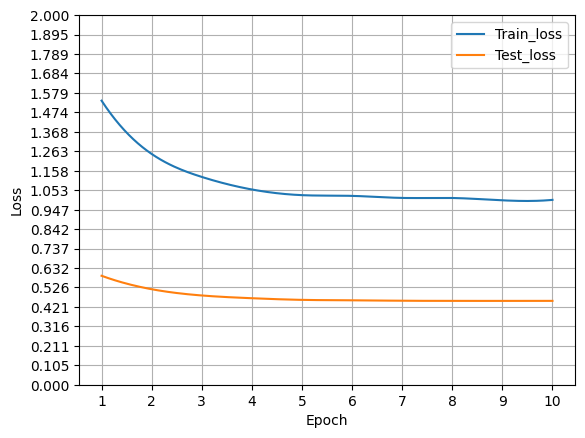

In [147]:
from scipy.interpolate import make_interp_spline, BSpline

#create data
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_loss_values)
y2 = np.array(test_loss_values)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_loss')
plt.plot(xnew, y_smooth2, label='Test_loss')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_loss_values + test_loss_values)), np.ceil(max(train_loss_values + test_loss_values)), 20))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

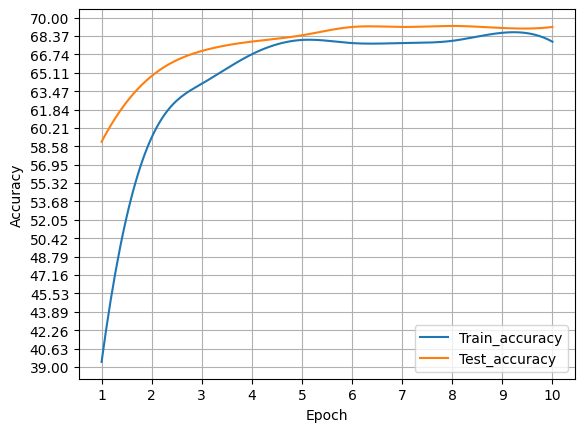

In [148]:
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_accuracy)
y2 = np.array(test_accuracy)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_accuracy')
plt.plot(xnew, y_smooth2, label='Test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_accuracy + test_accuracy)), np.ceil(max(train_accuracy + test_accuracy)), 20))
plt.grid()
plt.legend()
plt.show()

In [56]:
big_data = get_all_features_and_targets(n_cols=1000, do_fft=False)

In [57]:
big_data

,defect,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.501239,3.501345,3.502709,3.504820,3.504381,3.502747,3.502646,3.504854,8.332031,0.0
1,eccentricity,3.502895,3.501510,3.500999,3.501662,3.503309,3.501581,3.501134,3.501936,3.503558,...,3.503575,3.501831,3.503558,3.502181,3.502979,3.504715,3.504048,3.502291,8.332031,0.0
2,eccentricity,3.501375,3.503334,3.503929,3.503680,3.500994,3.503076,3.503947,3.505012,3.503701,...,3.503250,3.502772,3.502265,3.502519,3.502768,3.504175,3.503211,3.503334,8.332031,0.0
3,eccentricity,3.503022,3.503820,3.502059,3.502848,3.502494,3.503807,3.500906,3.503342,3.502878,...,3.501336,3.502983,3.503342,3.503216,3.502734,3.501222,3.502962,3.503465,8.332031,0.0
4,eccentricity,3.502743,3.501016,3.501932,3.502050,3.503474,3.501480,3.502037,3.502624,3.502654,...,3.503558,3.502992,3.502751,3.503465,3.503587,3.504043,3.502658,3.504179,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,tooth_chipped_fault,3.516108,3.490077,3.480503,3.538634,3.493571,3.497568,3.492015,3.505374,3.494644,...,3.497938,3.498709,3.504809,3.505048,3.509413,3.490649,3.516888,3.494272,40.000000,1.0
896,tooth_chipped_fault,3.494186,3.493973,3.484591,3.470970,3.496191,3.486603,3.522058,3.506896,3.513587,...,3.499302,3.500306,3.501734,3.500877,3.482042,3.504534,3.508308,3.490371,40.000000,1.0
897,tooth_chipped_fault,3.500929,3.506697,3.517205,3.524766,3.471116,3.522016,3.501702,3.454824,3.523714,...,3.502803,3.481030,3.507439,3.476587,3.522372,3.495078,3.492686,3.519807,40.000000,1.0
898,tooth_chipped_fault,3.481289,3.522285,3.502751,3.487161,3.537699,3.484394,3.488068,3.517876,3.489490,...,3.510549,3.492386,3.518726,3.484637,3.511213,3.498229,3.509970,3.495729,40.000000,1.0


In [61]:
num_cols = big_data.drop(columns=['defect', 'velocity', 'load']).columns
num_cols

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
      dtype='object', length=1000)

In [62]:
#scaler = StandardScaler()
#big_data[num_cols] = scaler.fit_transform(big_data[num_cols])
#big_data

In [63]:
big_data.defect.unique()

array(['eccentricity', 'missing_tooth', 'no_fault', 'root_crack',
       'surface_fault', 'tooth_chipped_fault'], dtype=object)

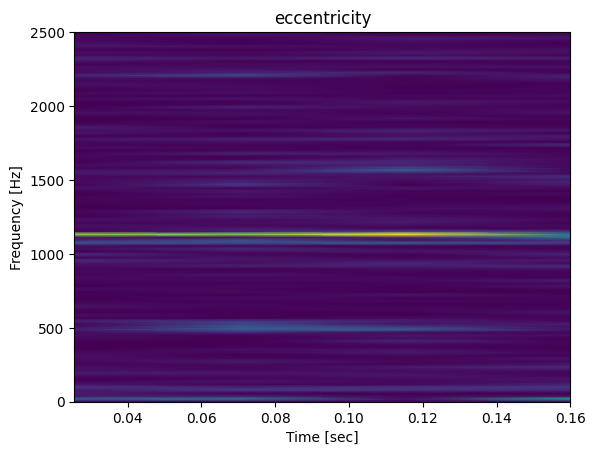

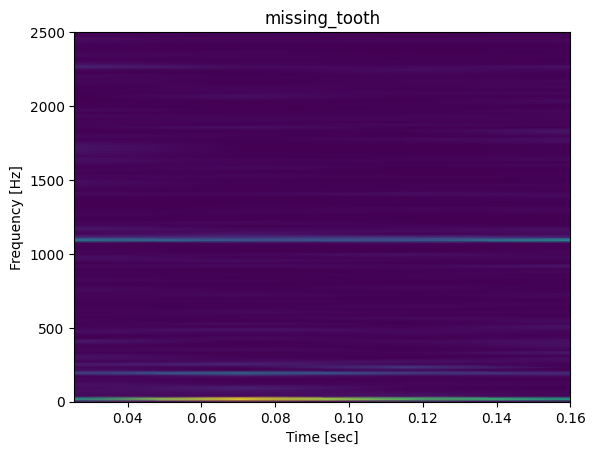

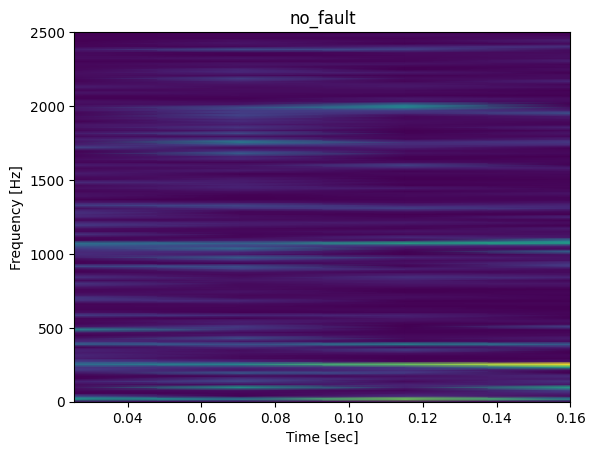

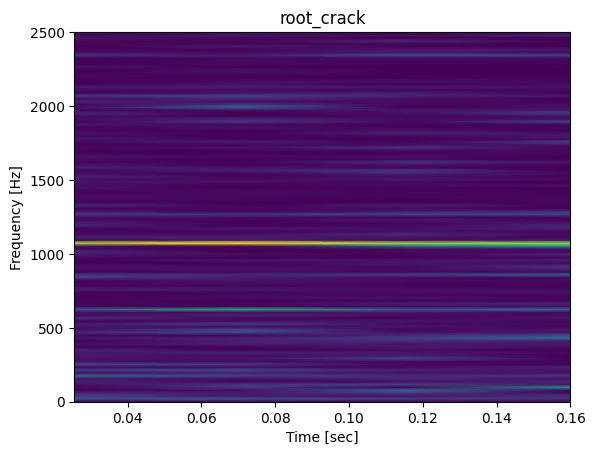

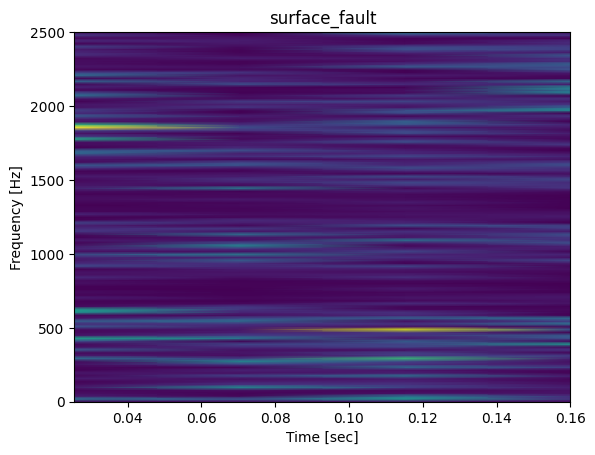

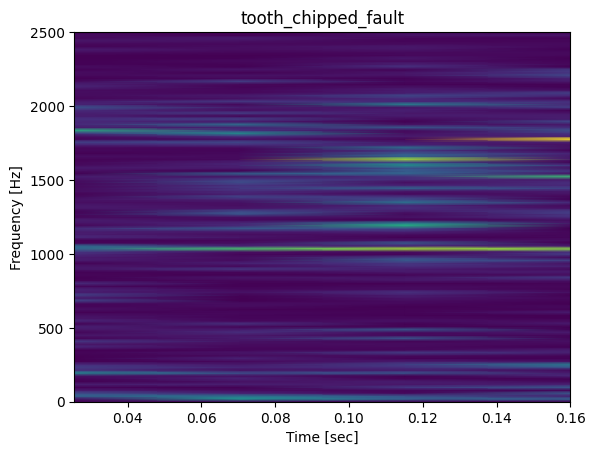

In [66]:
for defect_name in big_data.defect.unique():
    f, t, Sxx = signal.spectrogram(big_data[big_data['defect'] == defect_name].drop(columns=['defect', 'velocity', 'load']).values[0, :], fs=1/0.0002)

    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(defect_name)
    plt.show()

In [67]:
X = big_data.drop(columns=['defect', 'velocity', 'load']).values
X

array([[3.50379405, 3.50428424, 3.50129566, ..., 3.50274679, 3.50264556,
        3.50485411],
       [3.50289507, 3.50151028, 3.50099855, ..., 3.50471463, 3.50404767,
        3.50229077],
       [3.50137461, 3.50333378, 3.50392939, ..., 3.50417463, 3.5032113 ,
        3.50333378],
       ...,
       [3.50092924, 3.5066971 , 3.51720495, ..., 3.49507816, 3.49268602,
        3.51980659],
       [3.48128927, 3.52228483, 3.50275087, ..., 3.49822915, 3.50997008,
        3.49572876],
       [3.51628254, 3.48185533, 3.49677765, ..., 3.47839219, 3.48592561,
        3.52036249]])

In [68]:
y = big_data['defect'].values
y

array(['eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'no_fault', 'no_fault',
       'no_fault', 'no_fault', 'no_fault', 'no_fault', 'no_f

In [69]:
loads = big_data['load'].astype(int).values
loads

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [70]:
velocities = big_data['velocity'].astype(int).values
velocities

array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [71]:
current_directory_path = os.getcwd()
n = big_data.shape[0]
for i in tqdm(range(n)):
    f, t, Sxx = signal.spectrogram(X[i, :], fs=5000.0)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(os.path.join(current_directory_path,
                                 y[i],
                                 f"{velocities[i]}_{loads[i]}_{i}.png"))
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:19<00:00, 11.34it/s]


## Torch CV

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [73]:
directories = ['eccentricity', 'missing_tooth', 'no_fault', 'root_crack', 'surface_fault', 'tooth_chipped_fault']

In [74]:
list_images = []
list_labels = []
current_directory_path = os.getcwd()
for directory in directories:
    for image in os.listdir(directory):
        list_images.append(os.path.join(current_directory_path, directory, image))
        list_labels.append(directory)
d = pd.DataFrame({'path_to_image': list_images, 'label': list_labels})
encoder = LabelEncoder()
d['label'] = encoder.fit_transform(d['label'])
d.to_csv('annotation.csv')

In [75]:
d

,path_to_image,label
0,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
1,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
2,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
3,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
4,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
...,...,...
895,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5
896,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5
897,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5
898,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5


In [76]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=0)
        self.transform = transform
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels['path_to_image'][idx]
        image = read_image(img_path, mode=ImageReadMode.RGB)
        label = self.img_labels['label'][idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [77]:
transforms = v2.Compose([
    v2.Resize(size=(227, 227), antialias=True),  # Or Resize(antialias=True)
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [78]:
train_image_dataset = CustomImageDataset(annotations_file='annotation.csv', transform=transforms)

In [79]:
train_size = int(0.8 * len(train_image_dataset))
test_size = len(train_image_dataset) - train_size
generator1 = torch.Generator().manual_seed(861)
train_image_dataset, val_image_dataset = torch.utils.data.random_split(train_image_dataset, [train_size, test_size], generator=generator1)

In [80]:
train_dataloader = DataLoader(train_image_dataset, batch_size=6, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


root_crack


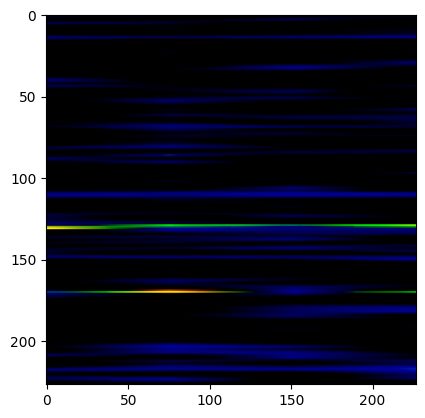

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eccentricity


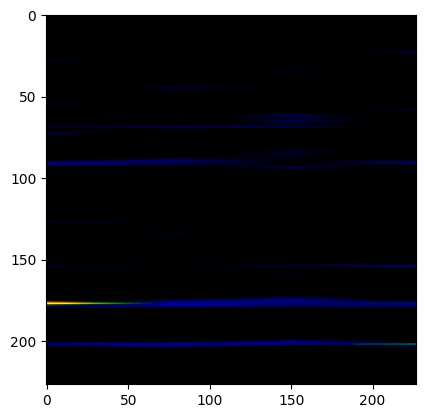

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


root_crack


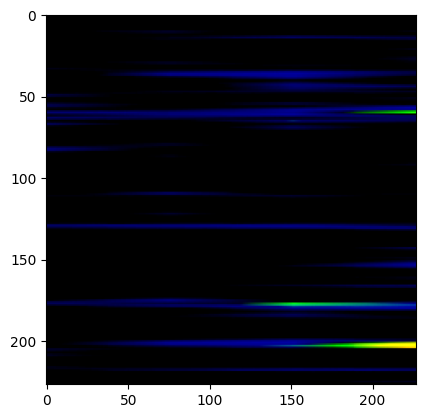

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


root_crack


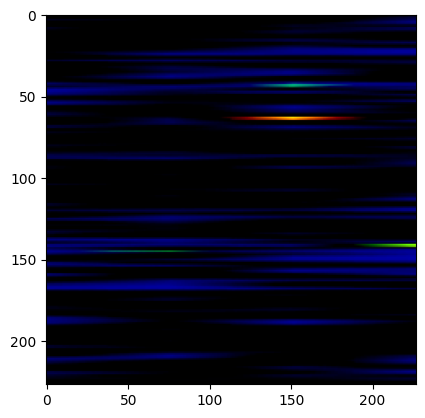

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


root_crack


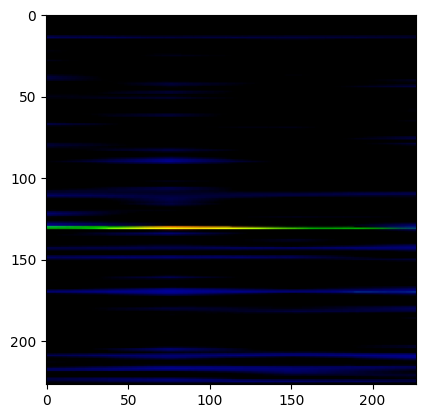

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tooth_chipped_fault


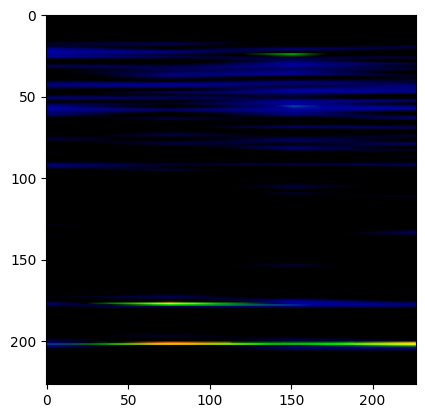

In [81]:
for X_train, y_train in train_dataloader:
    X_train = X_train
    y_train = y_train
    break
for i in range(X_train.size()[0]):
    label = np.array([y_train[i].item()])
    print(encoder.inverse_transform(label)[0])
    plt.imshow(X_train[i].permute(1, 2, 0))
    plt.show()

In [82]:
train_dataloader = DataLoader(train_image_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_image_dataset, batch_size=16, shuffle=True)

In [83]:
model = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights)
for param in model.parameters():
    param.requires_grad_ = False
model.fc.out_features = 6

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
criterion = torch.nn.CrossEntropyLoss()
optimezer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
scheduler = lr_scheduler.ExponentialLR(optimezer, gamma=0.5)

In [85]:
epochs = 10
train_loss_values = []
test_loss_values = []
train_accuracy = []
test_accuracy = []
model.to(device)
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, (X_train, label) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        label = label.to(device)
        optimezer.zero_grad()
        prediction = model(X_train)
        _, predictions = torch.max(prediction.data, 1)
        loss = criterion(prediction, label)
        loss.backward()
        optimezer.step()
        running_loss += loss.item()
        total += label.size(0)
        correct += (predictions == label).sum().item()
    print(f'Epoch №{epoch + 1}, Training loss = {running_loss / len(train_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on train = {correct / total * 100}%')
    train_loss_values.append(running_loss / len(train_dataloader))
    train_accuracy.append(correct / total * 100)
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for X_val, label_val in val_dataloader:
            X_val = X_val.to(device)
            label_val = label_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, label_val)
            running_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            total += label_val.size(0)
            correct += (predictions == label_val).sum().item()
    scheduler.step()
    print(f'Epoch №{epoch + 1}, Test loss = {running_loss / len(val_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on test = {correct / total * 100}%')
    test_loss_values.append(running_loss / len(train_dataloader))
    test_accuracy.append(correct / total * 100)
    print('----------------------------------------------------------------')

Epoch №1, Training loss = 2.412841949860255
Epoch №1, Accuracy on train = 51.66666666666667%
Epoch №1, Test loss = 0.7335117782155672
Epoch №1, Accuracy on test = 70.0%
----------------------------------------------------------------
Epoch №2, Training loss = 0.2069113560848766
Epoch №2, Accuracy on train = 95.13888888888889%
Epoch №2, Test loss = 0.2750193023433288
Epoch №2, Accuracy on test = 91.66666666666666%
----------------------------------------------------------------
Epoch №3, Training loss = 0.048929979326203465
Epoch №3, Accuracy on train = 99.44444444444444%
Epoch №3, Test loss = 0.1657389810619255
Epoch №3, Accuracy on test = 93.88888888888889%
----------------------------------------------------------------
Epoch №4, Training loss = 0.024581181325225368
Epoch №4, Accuracy on train = 100.0%
Epoch №4, Test loss = 0.19471540922919908
Epoch №4, Accuracy on test = 93.88888888888889%
----------------------------------------------------------------
Epoch №5, Training loss = 0.0

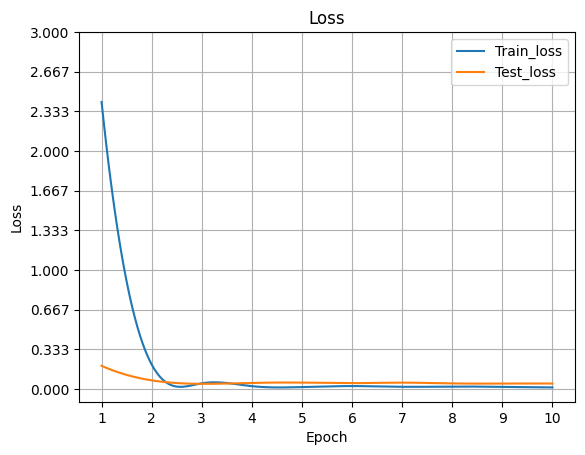

In [86]:
from scipy.interpolate import make_interp_spline

#create data
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_loss_values)
y2 = np.array(test_loss_values)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_loss')
plt.plot(xnew, y_smooth2, label='Test_loss')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_loss_values + test_loss_values)), np.ceil(max(train_loss_values + test_loss_values)), 10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

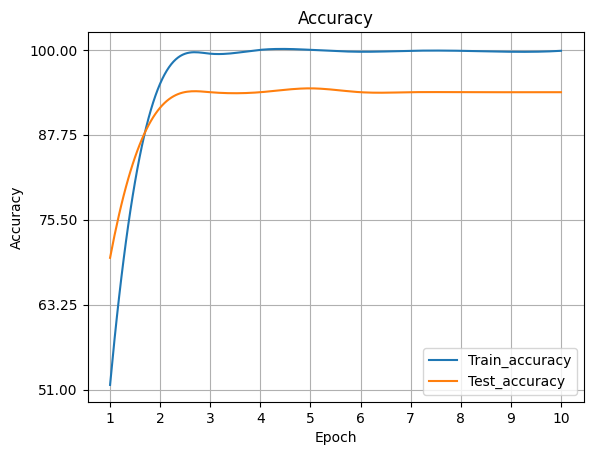

In [87]:
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_accuracy)
y2 = np.array(test_accuracy)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_accuracy')
plt.plot(xnew, y_smooth2, label='Test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_accuracy + test_accuracy)), np.ceil(max(train_accuracy + test_accuracy)), 5))
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()